## 0. Import Libraries

In [1]:
from glob import glob
from metpy.units import units
from shapely.geometry import mapping

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import geopandas as gpd

import rioxarray
import cartopy

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


## 1. Parameters

In [2]:
# ----------------------
# general path
path_general = 'data'
name_var = 'tp'

## 2. Open Data

UMD GLCF GLCDS lc: land cover data

### 2.1 LU Data

In [3]:
data_lu = rioxarray.open_rasterio(fr'{path_general}/land_use_data.tiff').squeeze()

In [4]:
data_lu.rio.crs

CRS.from_epsg(4326)

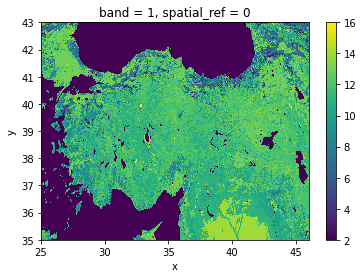

In [5]:
data_lu.plot()

In [6]:
data_lu.max()

<xarray.DataArray ()>
array(16, dtype=uint8)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

### 2.2 ERA5 Data

In [7]:
data_sample = xr.open_dataset(fr'{path_general}/aggregated_{name_var}_era5_monthhour')[name_var] \
                                    .mean(dim='month')
                                    #.stack(month_hour=('month', 'hour'))\
                                    #.transpose('month_hour', 'latitude', 'longitude')

In [8]:
data_sample

<xarray.DataArray 'tp' (hour: 24, latitude: 33, longitude: 85)>
array([[[4.87828484e+01, 4.75846977e+01, 4.31989632e+01, ...,
         1.34441483e+02, 1.42702805e+02, 1.21349220e+02],
        [3.79171181e+01, 3.94532509e+01, 3.94015045e+01, ...,
         1.29276062e+02, 1.58582687e+02, 8.81046066e+01],
        [2.93677063e+01, 2.99684143e+01, 2.80243587e+01, ...,
         4.67116203e+01, 5.11617737e+01, 5.12977943e+01],
        ...,
        [3.46036172e+00, 2.19538212e+00, 1.82639074e+00, ...,
         3.64221632e-02, 2.18531732e-02, 2.03462932e-02],
        [1.88227499e+00, 1.28080857e+00, 9.61044848e-01, ...,
         2.78822463e-02, 1.05500221e-02, 0.00000000e+00],
        [8.89959097e-01, 2.65382230e-01, 1.00099169e-01, ...,
         5.40042901e-03, 6.28021837e-04, 0.00000000e+00]],

       [[4.55511932e+01, 4.44530144e+01, 4.51883545e+01, ...,
         1.34054642e+02, 1.40007294e+02, 1.21864807e+02],
        [3.22454376e+01, 3.47625847e+01, 3.72468224e+01, ...,
         1.29773178e+02, 1.56245224e+02, 8.48406906e+01],
        [2.52798862e+01, 2.57465954e+01, 2.51014156e+01, ...,
         4.82189789e+01, 5.23589363e+01, 5.08354797e+01],
...
        [1.99920404e+00, 1.36947858e+00, 1.16903484e+00, ...,
         2.00948375e-03, 1.63260847e-03, 0.00000000e+00],
        [6.55601501e-01, 4.82407421e-01, 4.74997759e-01, ...,
         1.09268976e-02, 0.00000000e+00, 0.00000000e+00],
        [2.08864287e-01, 8.70373771e-02, 2.38629356e-01, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[4.77160530e+01, 4.90158195e+01, 4.53098106e+01, ...,
         1.38076401e+02, 1.43877304e+02, 1.21341316e+02],
        [4.02094574e+01, 4.16635780e+01, 4.31156960e+01, ...,
         1.31462753e+02, 1.57843277e+02, 9.17475967e+01],
        [3.22985649e+01, 3.10566864e+01, 2.85847473e+01, ...,
         4.38567238e+01, 5.02689018e+01, 5.28705940e+01],
        ...,
        [2.82711673e+00, 1.94871485e+00, 1.56703937e+00, ...,
         1.65784732e-02, 1.79599356e-02, 0.00000000e+00],
        [1.07043803e+00, 7.71776199e-01, 6.78711891e-01, ...,
         1.63270161e-02, 1.09265866e-02, 0.00000000e+00],
        [2.98411578e-01, 1.10146903e-01, 1.28734872e-01, ...,
         6.28021837e-04, 5.02293289e-04, 0.00000000e+00]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 25.0 25.25 25.5 25.75 ... 45.5 45.75 46.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 35.5 35.25 35.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23

In [9]:
np.unique(data_lu.values)

array([ 2,  3,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16], dtype=uint8)

## 3. Metadata Definition

In [10]:
def define_index_correspondence():
    
    indexes = {
        'water' : np.arange(0,3), # 1 to 11 included
        'Evergreen Needleleaf Forest' : np.arange(3,4), # 12 to 22 included
        'Evergreen Broadleaf Forest' : np.arange(4,5), # 23 to 34 included
        'Deciduous Needleleaf Forest' : np.arange(5,6), # 35 to 39 included
        'Deciduous Broadleaf Forest' : np.arange(6,7), # 40 to 45 included
        'Mixed Forest': np.arange(7,8), # all grids
        'Woodland': np.arange(8,9), # all but not water
        'Wooded Grassland': np.arange(9,10), # all but not water
        'Closed Shrubland': np.arange(10,11), # all but not water
        'Open Shrubland': np.arange(11,12), # all but not water
        'Grassland': np.arange(12,13), # all but not water
        'Cropland': np.arange(13,14), # all but not water
        'Bare Ground': np.arange(14, 15), # all but not water
        'Urban and Built-up': np.arange(15, 17), # all but not water
    }
    
    return indexes

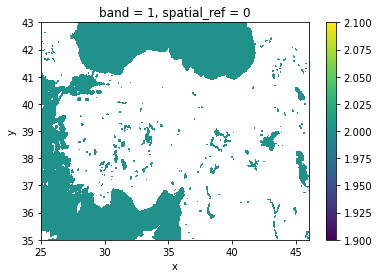

In [11]:
# define land-use index correspondence of name
indexes = define_index_correspondence()
index = 'water'

data_lu.where(data_lu.isin(indexes[index])).plot()

## 4. Regrid

In [12]:
# define globe
globe = cartopy.crs.Globe(ellipse='sphere',
                          semimajor_axis=6370000,
                          semiminor_axis=6370000)
# define observation projection
proj_obs = cartopy.crs.CRS('EPSG:4326',
                          )

# write projection
data_sample = data_sample.rio.write_crs(proj_obs)

# set spatial dims for ERA5
data_sample = data_sample.rio.set_spatial_dims(x_dim='longitude',
                                               y_dim='latitude')

# set spatial dims for land use data
data_lu = data_lu.rio.set_spatial_dims(x_dim='x',
                                       y_dim='y')


data_sample.rio.crs

CRS.from_epsg(4326)

In [13]:
def regrid_match(dt_to_match, dt_to_be_matched):
    
    """
    Regrid a file grid to a target grid. Requires input data array
    
    Return target file and regridded file
    
    """
    # reproject
    dt_to_be_matched = dt_to_be_matched.rio.reproject_match(dt_to_match)
    
    return dt_to_be_matched

In [14]:
dt_obs_regrid = regrid_match(data_lu, data_sample,
                             )
#dt_obs_regrid = dt_obs_regrid.unstack()

In [15]:
dt_obs_regrid

<xarray.DataArray 'tp' (hour: 24, y: 960, x: 2520)>
array([[[ 48.78285   ,  48.78285   ,  48.78285   , ..., 121.34922   ,
         121.34922   , 121.34922   ],
        [ 48.78285   ,  48.78285   ,  48.78285   , ..., 121.34922   ,
         121.34922   , 121.34922   ],
        [ 48.78285   ,  48.78285   ,  48.78285   , ..., 121.34922   ,
         121.34922   , 121.34922   ],
        ...,
        [  0.8899591 ,   0.8899591 ,   0.8899591 , ...,   0.        ,
           0.        ,   0.        ],
        [  0.8899591 ,   0.8899591 ,   0.8899591 , ...,   0.        ,
           0.        ,   0.        ],
        [  0.8899591 ,   0.8899591 ,   0.8899591 , ...,   0.        ,
           0.        ,   0.        ]],

       [[ 45.551193  ,  45.551193  ,  45.551193  , ..., 121.86481   ,
         121.86481   , 121.86481   ],
        [ 45.551193  ,  45.551193  ,  45.551193  , ..., 121.86481   ,
         121.86481   , 121.86481   ],
        [ 45.551193  ,  45.551193  ,  45.551193  , ..., 121.86481   ,
         121.86481   , 121.86481   ],
...
        [  0.20886429,   0.20886429,   0.20886429, ...,   0.        ,
           0.        ,   0.        ],
        [  0.20886429,   0.20886429,   0.20886429, ...,   0.        ,
           0.        ,   0.        ],
        [  0.20886429,   0.20886429,   0.20886429, ...,   0.        ,
           0.        ,   0.        ]],

       [[ 47.716053  ,  47.716053  ,  47.716053  , ..., 121.34132   ,
         121.34132   , 121.34132   ],
        [ 47.716053  ,  47.716053  ,  47.716053  , ..., 121.34132   ,
         121.34132   , 121.34132   ],
        [ 47.716053  ,  47.716053  ,  47.716053  , ..., 121.34132   ,
         121.34132   , 121.34132   ],
        ...,
        [  0.29841158,   0.29841158,   0.29841158, ...,   0.        ,
           0.        ,   0.        ],
        [  0.29841158,   0.29841158,   0.29841158, ...,   0.        ,
           0.        ,   0.        ],
        [  0.29841158,   0.29841158,   0.29841158, ...,   0.        ,
           0.        ,   0.        ]]], dtype=float32)
Coordinates:
  * x            (x) float64 25.0 25.01 25.02 25.03 ... 45.97 45.98 45.99 46.0
  * y            (y) float64 43.0 42.99 42.98 42.97 ... 35.03 35.02 35.01 35.0
  * hour         (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
    spatial_ref  int64 0
Attributes:
    _FillValue:  3.402823466e+38

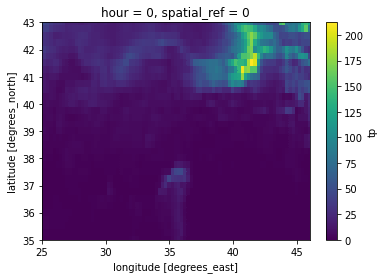

In [16]:
dt_obs_regrid[0].plot()

In [17]:
dt_obs_regrid.rio.crs

CRS.from_epsg(4326)

## 5. Clip to Turkey

In [18]:
def clip_to_city(data, shapefile):
    
    clipped = data.rio.clip(shapefile.geometry.apply(mapping),
                            shapefile.crs, all_touched=True, 
                            invert=False, from_disk=True)
    
    return clipped

In [19]:
shape_tr = gpd.read_file(fr'{path_general}/shapefiles/Iller_HGK_6360_Kanun_Sonrasi.shp')

In [20]:
dt_obs_regrid_tr = clip_to_city(dt_obs_regrid, shape_tr)

# change nodata to np.nan
nodata = dt_obs_regrid_tr.rio.nodata
dt_obs_regrid_tr = dt_obs_regrid_tr.where(dt_obs_regrid_tr != nodata, np.nan)

/home/donmezk16/Downloads/anaconda3/envs/AFAD/lib/python3.9/site-packages/rioxarray/raster_writer.py:108: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


## 6. Filter Data Based on Land Use

In [21]:
list(indexes.keys())

['water',
 'Evergreen Needleleaf Forest',
 'Evergreen Broadleaf Forest',
 'Deciduous Needleleaf Forest',
 'Deciduous Broadleaf Forest',
 'Mixed Forest',
 'Woodland',
 'Wooded Grassland',
 'Closed Shrubland',
 'Open Shrubland',
 'Grassland',
 'Cropland',
 'Bare Ground',
 'Urban and Built-up']

In [22]:
dict_lu_mask = {}

for index in list(indexes.keys()):
    
    if index not in ['Evergreen Broadleaf Forest',
                     'Deciduous Needleleaf Forest',
                    ]:
        masked = dt_obs_regrid_tr.where(data_lu.isin(indexes[index])).stack(spatial=('y', 'x'))
        dict_lu_mask[index] = masked.mean(dim='spatial').values

## 7. Save CSV

In [23]:
pd.DataFrame(dict_lu_mask).to_excel(fr'{path_general}/{name_var}_filtered_dataframe_hourly.xlsx', 
                                    index=False)